✅ Libraries Loaded Successfully.

✅ Data Ready! Regime detected. Total Rows: 5348
✅ Data Ready with columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'Log_Ret', 'Parkinson_Vol', 'Close_Loc', 'SMA_20', 'Dist_SMA_20', 'SMA_200', 'Regime', 'RSI']
🚀 Model will use 5 Features: ['Log_Ret', 'Dist_SMA_20', 'RSI', 'Parkinson_Vol', 'Close_Loc']
✅ Data is clean and finite. Scaler should work now.

Class Weights: {0: np.float64(0.4648862512363996), 1: np.float64(2.9936305732484074), 2: np.float64(1.9421487603305785)}

Starting Training with Multi-Feature Technical Indicators...
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.3241 - loss: 1.2992 - val_accuracy: 0.4471 - val_loss: 1.0840 - learning_rate: 5.0000e-04
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.3433 - loss: 1.2244 - val_accuracy: 0.4584 - val_loss: 1.0719 - learning_rate: 5.0000e-04
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.3539 - loss: 1.1781 - val_accuracy: 0.4499 - val_

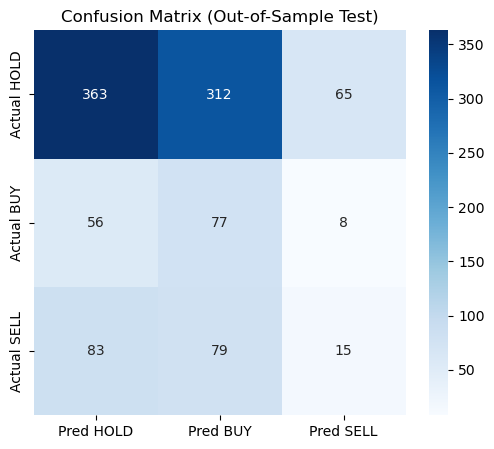

              precision    recall  f1-score   support

        HOLD       0.72      0.49      0.58       740
         BUY       0.16      0.55      0.25       141
        SELL       0.17      0.08      0.11       177

    accuracy                           0.43      1058
   macro avg       0.35      0.37      0.32      1058
weighted avg       0.56      0.43      0.46      1058


--- BACKTEST: AI vs BUY & HOLD ---


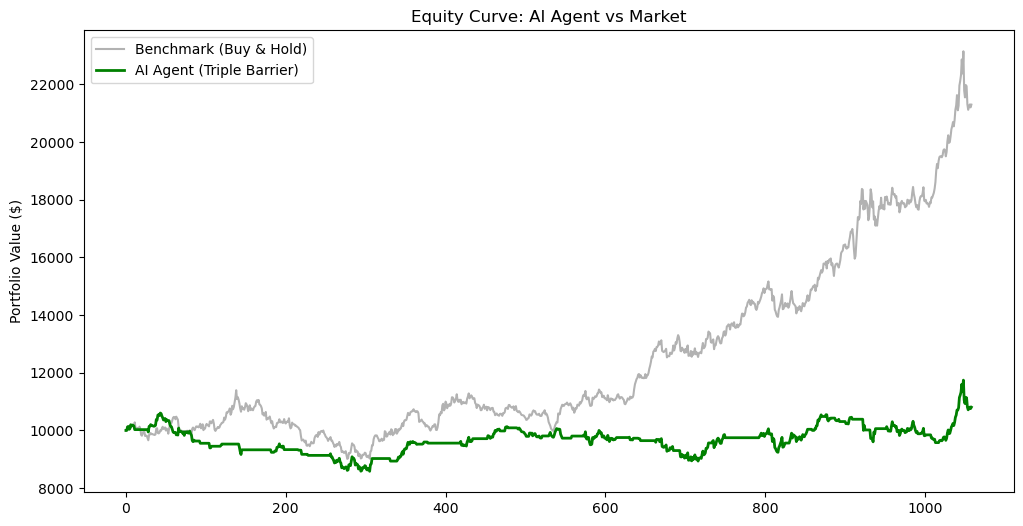

Final AI Value: $10806.98
Final Benchmark: $21299.44

--- 🔮 FORECAST FOR TOMORROW ---
Probabilities: [HOLD: 0.28, BUY: 0.38, SELL: 0.34]

🤖 AI RECOMMENDATION: BUY (Aggressive Entry)
📝 DETAILS:        Trend is strong. Enter Long.
📊 CONFIDENCE:     38.2%
✅ FILE SAVED: Gold_BULL_Specialist.keras
✅ READY: The Manager can now call this file for Bull Regimes.


In [61]:
# =============================================================
# 🚀 MODEL A: THE "AGGRESSIVE BULL" SPECIALIST
# FOCUS: Trend-Following & Momentum Capture
# MODE: High-Conviction / "Diamond Hands"
# LOGIC: Sensitive to Buy signals, ignores minor drawdowns.
# =============================================================

# --- PART 1: IMPORTS & SETUP ---
#"Data Analysts"
import numpy as np
import pandas as pd

#"Data Supplier"
import yfinance as yf

#"Visualization"
import matplotlib.pyplot as plt
import seaborn as sns

#"clean and prepapre data"
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

#"Deep Learning Framework"
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries Loaded Successfully.")

# --- PART 2: DATA INGESTION & INDICATORS ---
print("\nDownloading Data and Calculating Indicators...")
data = yf.download('GC=F', start='2004-01-01', end='2026-02-01', progress=False)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# 1. Log Returns
data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))

# 2. Parkinson Volatility (Intra-day Risk)
data['Parkinson_Vol'] = (1.0 / (4.0 * np.log(2.0))) * ((np.log(data['High'] / data['Low'].replace(0, 1e-9))) ** 2)

# 3. Buying/Selling Pressure (Conviction)
data['Close_Loc'] = (data['Close'] - data['Low']) / (data['High'] - data['Low']).replace(0, 1e-9)

# 4. SMA Distance (Short-term Trend)
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['Dist_SMA_20'] = (data['Close'] - data['SMA_20']) / data['SMA_20']

# 5. REGIME GATING (Long-term Trend)
data['SMA_200'] = data['Close'].rolling(window=200).mean()
# 1 = Bull Market, 0 = Bear/Chop
data['Regime'] = np.where(data['Close'] > data['SMA_200'], 1, 0)

# 6. RSI (Momentum)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss.replace(0, 1e-9) # Added stability buffer
data['RSI'] = 100 - (100 / (1 + rs))

# 7. CRITICAL CLEANUP
# Since SMA_200 takes 200 days to calculate, the first 200 rows are now NaN.
# We must drop them or the Scaler will fail.
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# 6. Cleanup
data.dropna(inplace=True)

# 7. UPDATE FEATURE LIST (Crucial Step)
# We now have 5 features instead of 3
features = ['Log_Ret', 'Dist_SMA_20', 'RSI', 'Parkinson_Vol', 'Close_Loc']

print(f"✅ Data Ready! Regime detected. Total Rows: {len(data)}")
print(f"✅ Data Ready with columns: {data.columns.tolist()}")
print(f"🚀 Model will use {len(features)} Features: {features}")

# --- CRITICAL CLEANUP ---
# 1. Replace any remaining Infinity values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2. Drop all NaNs (This removes the 20 days of SMA/RSI buildup AND the infinity errors)
data.dropna(inplace=True)

# 3. Final Safety Check (This will tell you if the error is gone)
if np.isinf(data[features].values).any():
    print("❌ Still have Infinity values!")
else:
    print("✅ Data is clean and finite. Scaler should work now.")

# --- PART 3: BULL SPECIALIST LABELING ---
volatility = data['Log_Ret'].rolling(window=20).std()
raw_returns = data['Log_Ret'].values
vol_values = volatility.values
bull_labels = []

# BULL SPECIALIST TUNERS:
upward_multiplier = 0.75    # Aggressive: Buy on even slight strength
downward_multiplier = 1.5  # Stubborn: Ignore most "downticks"

for i in range(len(raw_returns)):
    vol = vol_values[i]
    if np.isnan(vol):
        bull_labels.append(0)
        continue

    if raw_returns[i] > (vol * upward_multiplier):
        bull_labels.append(1) # BUY
    elif raw_returns[i] < -(vol * downward_multiplier):
        bull_labels.append(2) # SELL (Only if it's a massive crash)
    else:
        bull_labels.append(0) # HOLD

# --- PART 4 CORRECTION: MULTI-FEATURE WINDOWING ---
from sklearn.preprocessing import StandardScaler

# 1. Define the features you created in Part 2
features = ['Log_Ret', 'Dist_SMA_20', 'RSI', 'Parkinson_Vol', 'Close_Loc'] 

# 2. Use StandardScaler (Crucial for multi-feature models)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])

X, y = [], []
time_steps = 60

for i in range(time_steps, len(scaled_features)):
    # Grab all 3 columns for the 60-day window
    X.append(scaled_features[i-time_steps:i, :]) 
    y.append(smart_labels[i])

X, y = np.array(X), np.array(y)

# 3. Split the 3D data
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# --- PART 5: MODEL TRAINING (THE LSTM BRAIN) ---
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import BatchNormalization, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# 1. Calculate Class Weights (Essential for 3-class models)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"\nClass Weights: {class_weight_dict}")

# 2. Define the Architecture
model = Sequential([
    # We use (60, 3) because Part 4 now provides 3 features
    Bidirectional(LSTM(100, return_sequences=True, input_shape=(60, 5))),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(50, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dense(3, activation='softmax') # HOLD, BUY, SELL
])

# 3. Compile with a stable learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# 4. Define Safety Nets
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# 5. Train
print("\nStarting Training with Multi-Feature Technical Indicators...")
history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_test, y_test),
                    class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

# --- PART 6: EVALUATION (THE TRUTH TEST) ---
print("\n--- PERFORMANCE REPORT ---")
probs = model.predict(X_test)
preds = np.argmax(probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred HOLD', 'Pred BUY', 'Pred SELL'], 
            yticklabels=['Actual HOLD', 'Actual BUY', 'Actual SELL'])
plt.title('Confusion Matrix (Out-of-Sample Test)')
plt.show()

# Precision/Recall Report
print(classification_report(y_test, preds, target_names=['HOLD', 'BUY', 'SELL']))

# --- PART 7: PROFITABILITY SIMULATION (BACKTEST) ---
print("\n--- BACKTEST: AI vs BUY & HOLD ---")
initial_cash = 10000
ai_cash = initial_cash
benchmark_cash = initial_cash
ai_curve = [initial_cash]
benchmark_curve = [initial_cash]
position = 0 # 0=Cash, 1=Long, -1=Short

# Get real returns for the test period
test_returns = raw_returns[split:]

for i in range(len(preds)):
    ret = test_returns[i]
    signal = preds[i]
    
    # Update Benchmark
    benchmark_cash *= (1 + ret)
    benchmark_curve.append(benchmark_cash)
    
    # Update AI Portfolio
    if position == 1: ai_cash *= (1 + ret)
    elif position == -1: ai_cash *= (1 - ret)
        
    # Make Decision for NEXT DAY
    if signal == 1: position = 1     # BUY
    elif signal == 2: position = -1  # SELL
    else: position = 0               # HOLD (Cash)
    
    ai_curve.append(ai_cash)

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(benchmark_curve, label='Benchmark (Buy & Hold)', color='gray', alpha=0.6)
plt.plot(ai_curve, label='AI Agent (Triple Barrier)', color='green', linewidth=2)
plt.title('Equity Curve: AI Agent vs Market')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

print(f"Final AI Value: ${ai_cash:.2f}")
print(f"Final Benchmark: ${benchmark_cash:.2f}")

# --- PART 8: LIVE FORECAST (TOMORROW) ---
print("\n--- 🔮 FORECAST FOR TOMORROW ---")

# 1. Grab the latest 60 days of ALL 5 features
# These are: ['Log_Ret', 'Dist_SMA_20', 'RSI', 'Parkinson_Vol', 'Close_Loc']
# Using data[features] ensures we pull exactly what was defined in Part 2
last_60_raw = data[features].tail(60).values

# 2. Scale them using the SAME 'scaler' object from Part 4
# This is vital! Scaling ensures 'RSI' and 'Vol' are in the same math range
last_60_scaled = scaler.transform(last_60_raw)

# 3. Reshape to (1 Sample, 60 Days, 5 Features)
# Note: The '5' here must match the '5' in your Part 5 input_shape
X_live = np.reshape(last_60_scaled, (1, 60, 5))

# 4. Predict using the model currently in memory (The one you just trained)
live_probs = model.predict(X_live, verbose=0)[0]
decision_idx = np.argmax(live_probs)
confidence = live_probs[decision_idx] * 100

# 3. Output Results (With Sticky Hold Logic)
print(f"Probabilities: [HOLD: {live_probs[0]:.2f}, BUY: {live_probs[1]:.2f}, SELL: {live_probs[2]:.2f}]")

if decision_idx == 0:
    recommendation = "HOLD (Maintain Momentum)"
    details = "Ignore minor dips. If Long, stay Long."
elif decision_idx == 1:
    recommendation = "BUY (Aggressive Entry)"
    details = "Trend is strong. Enter Long."
else:
    recommendation = "SELL (Major Reversal)"
    details = "High certainty crash detected. Exit/Short."

print(f"\n🤖 AI RECOMMENDATION: {recommendation}")
print(f"📝 DETAILS:        {details}")
print(f"📊 CONFIDENCE:     {confidence:.1f}%")

# Save the updated model
# At the end of Part 5 training:
# 4. CRITICAL: Save as the Bull Specialist
save_name = "Gold_BULL_Specialist.keras"
model.save(save_name)

print(f"✅ FILE SAVED: {save_name}")
print("✅ READY: The Manager can now call this file for Bull Regimes.")

✅ Libraries Loaded Successfully.

✅ Data Ready! Regime detected. Total Rows: 5348
✅ Data Ready with columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'Log_Ret', 'Parkinson_Vol', 'Close_Loc', 'SMA_20', 'Dist_SMA_20', 'SMA_200', 'Regime', 'RSI']
🚀 Model will use 5 Features: ['Log_Ret', 'Dist_SMA_20', 'RSI', 'Parkinson_Vol', 'Close_Loc']
✅ Data is clean and finite. Scaler should work now.

Generating Smart Labels with Downward Sensitivity...

Class Weights: {0: np.float64(0.4648862512363996), 1: np.float64(2.9936305732484074), 2: np.float64(1.9421487603305785)}

Starting Training with Multi-Feature Technical Indicators...
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.3433 - loss: 1.3366 - val_accuracy: 0.1853 - val_loss: 1.1078 - learning_rate: 5.0000e-04
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.3506 - loss: 1.2469 - val_accuracy: 0.2883 - val_loss: 1.1043 - learning_rate: 5.0000e-04
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accurac

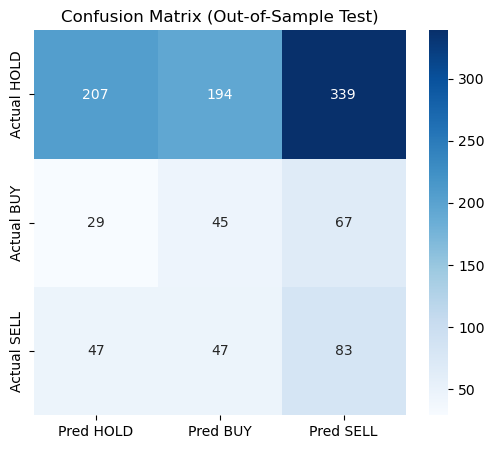

              precision    recall  f1-score   support

        HOLD       0.73      0.28      0.40       740
         BUY       0.16      0.32      0.21       141
        SELL       0.17      0.47      0.25       177

    accuracy                           0.32      1058
   macro avg       0.35      0.36      0.29      1058
weighted avg       0.56      0.32      0.35      1058


--- BACKTEST: AI vs BUY & HOLD ---


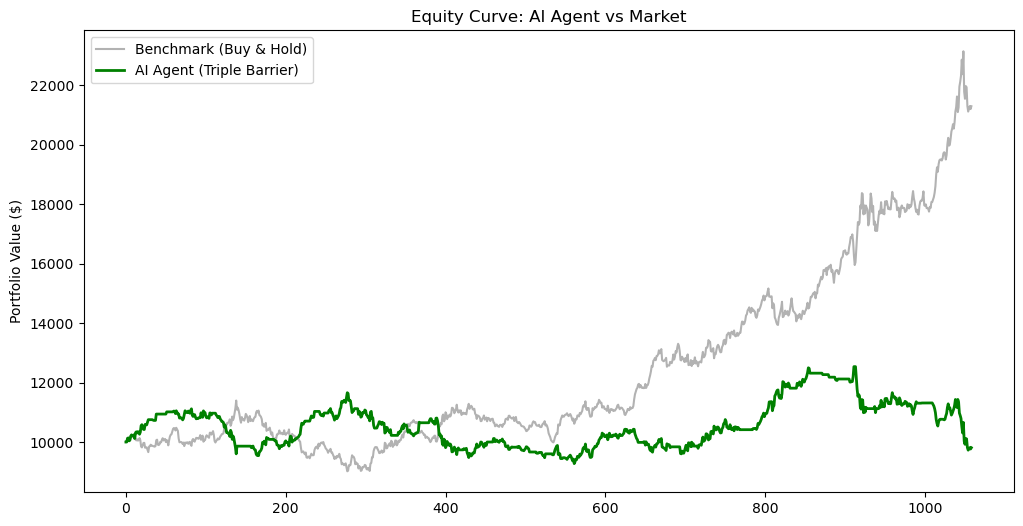

Final AI Value: $9808.70
Final Benchmark: $21299.44

--- 🔮 FORECAST FOR TOMORROW ---
Probabilities:
  - HOLD: 0.39
  - BUY:  0.21
  - SELL: 0.40

🤖 AI RECOMMENDATION: SELL (Short) (40.2% Confidence)

✅ Defensive Model Saved. Ready for Bear/Chop regimes.


In [71]:
# =============================================================
# 🛡️ MODEL B: THE "DEFENSIVE BEAR" SPECIALIST
# FOCUS: Capital Preservation & Risk Management
# MODE: Conservative / "Safety First"
# LOGIC: Sensitive to Sell signals, ignores "Dead Cat" rallies.
# =============================================================

# --- PART 1: IMPORTS & SETUP ---
#"Data Analysts"
import numpy as np
import pandas as pd

#"Data Supplier"
import yfinance as yf

#"Visualization"
import matplotlib.pyplot as plt
import seaborn as sns

#"clean and prepapre data"
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

#"Deep Learning Framework"
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries Loaded Successfully.")

# --- PART 2: DATA INGESTION & INDICATORS ---
print("\nDownloading Data and Calculating Indicators...")
data = yf.download('GC=F', start='2004-01-01', end='2026-02-01', progress=False)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# 1. Log Returns
data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))

# 2. Parkinson Volatility (Intra-day Risk)
data['Parkinson_Vol'] = (1.0 / (4.0 * np.log(2.0))) * ((np.log(data['High'] / data['Low'].replace(0, 1e-9))) ** 2)

# 3. Buying/Selling Pressure (Conviction)
data['Close_Loc'] = (data['Close'] - data['Low']) / (data['High'] - data['Low']).replace(0, 1e-9)

# 4. SMA Distance (Short-term Trend)
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['Dist_SMA_20'] = (data['Close'] - data['SMA_20']) / data['SMA_20']

# 5. REGIME GATING (Long-term Trend)
data['SMA_200'] = data['Close'].rolling(window=200).mean()
# 1 = Bull Market, 0 = Bear/Chop
data['Regime'] = np.where(data['Close'] > data['SMA_200'], 1, 0)

# 6. RSI (Momentum)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss.replace(0, 1e-9) # Added stability buffer
data['RSI'] = 100 - (100 / (1 + rs))

# 7. CRITICAL CLEANUP
# Since SMA_200 takes 200 days to calculate, the first 200 rows are now NaN.
# We must drop them or the Scaler will fail.
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# 6. Cleanup
data.dropna(inplace=True)

# 7. UPDATE FEATURE LIST (Crucial Step)
# We now have 5 features instead of 3
features = ['Log_Ret', 'Dist_SMA_20', 'RSI', 'Parkinson_Vol', 'Close_Loc']

print(f"✅ Data Ready! Regime detected. Total Rows: {len(data)}")
print(f"✅ Data Ready with columns: {data.columns.tolist()}")
print(f"🚀 Model will use {len(features)} Features: {features}")

# --- CRITICAL CLEANUP ---
# 1. Replace any remaining Infinity values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2. Drop all NaNs (This removes the 20 days of SMA/RSI buildup AND the infinity errors)
data.dropna(inplace=True)

# 3. Final Safety Check (This will tell you if the error is gone)
if np.isinf(data[features].values).any():
    print("❌ Still have Infinity values!")
else:
    print("✅ Data is clean and finite. Scaler should work now.")

# --- PART 3: ASYMMETRIC TRIPLE BARRIER LABELING ---
volatility = data['Log_Ret'].rolling(window=20).std()
raw_returns = data['Log_Ret'].values
vol_values = volatility.values
smart_labels = []

# ADJUST THESE TUNERS:
upward_multiplier = 1.2    # Require a strong move to buy
downward_multiplier = 0.8  # Exit/Short much faster on weakness (Lower = More Sensitive)

print("\nGenerating Smart Labels with Downward Sensitivity...")
for i in range(len(raw_returns)):
    vol = vol_values[i]
    
    if np.isnan(vol):
        smart_labels.append(0)
        continue

    # Logic: We make the 'SELL' floor much closer than the 'BUY' ceiling
    if raw_returns[i] > (vol * upward_multiplier):
        smart_labels.append(1) # BUY
    elif raw_returns[i] < -(vol * downward_multiplier):
        smart_labels.append(2) # SELL (Triggers more easily now)
    else:
        smart_labels.append(0) # HOLD

# --- PART 4 CORRECTION: MULTI-FEATURE WINDOWING ---
from sklearn.preprocessing import StandardScaler

# 1. Define the features you created in Part 2
features = ['Log_Ret', 'Dist_SMA_20', 'RSI', 'Parkinson_Vol', 'Close_Loc'] 

# 2. Use StandardScaler (Crucial for multi-feature models)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])

X, y = [], []
time_steps = 60

for i in range(time_steps, len(scaled_features)):
    # Grab all 3 columns for the 60-day window
    X.append(scaled_features[i-time_steps:i, :]) 
    y.append(smart_labels[i])

X, y = np.array(X), np.array(y)

# 3. Split the 3D data
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# --- PART 5: MODEL TRAINING (THE LSTM BRAIN) ---
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import BatchNormalization, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# 1. Calculate Class Weights (Essential for 3-class models)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"\nClass Weights: {class_weight_dict}")

# 2. Define the Architecture
model = Sequential([
    # We use (60, 3) because Part 4 now provides 3 features
    Bidirectional(LSTM(100, return_sequences=True, input_shape=(60, 5))),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(50, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dense(3, activation='softmax') # HOLD, BUY, SELL
])

# 3. Compile with a stable learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# 4. Define Safety Nets
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# 5. Train
print("\nStarting Training with Multi-Feature Technical Indicators...")
history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_test, y_test),
                    class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

# --- PART 6: EVALUATION (THE TRUTH TEST) ---
print("\n--- PERFORMANCE REPORT ---")
probs = model.predict(X_test)
preds = np.argmax(probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred HOLD', 'Pred BUY', 'Pred SELL'], 
            yticklabels=['Actual HOLD', 'Actual BUY', 'Actual SELL'])
plt.title('Confusion Matrix (Out-of-Sample Test)')
plt.show()

# Precision/Recall Report
print(classification_report(y_test, preds, target_names=['HOLD', 'BUY', 'SELL']))

# --- PART 7: PROFITABILITY SIMULATION (BACKTEST) ---
print("\n--- BACKTEST: AI vs BUY & HOLD ---")
initial_cash = 10000
ai_cash = initial_cash
benchmark_cash = initial_cash
ai_curve = [initial_cash]
benchmark_curve = [initial_cash]
position = 0 # 0=Cash, 1=Long, -1=Short

# Get real returns for the test period
test_returns = raw_returns[split:]

for i in range(len(preds)):
    ret = test_returns[i]
    signal = preds[i]
    
    # Update Benchmark
    benchmark_cash *= (1 + ret)
    benchmark_curve.append(benchmark_cash)
    
    # Update AI Portfolio
    if position == 1: ai_cash *= (1 + ret)
    elif position == -1: ai_cash *= (1 - ret)
        
    # Make Decision for NEXT DAY
    if signal == 1: position = 1     # BUY
    elif signal == 2: position = -1  # SELL
    else: position = 0               # HOLD (Cash)
    
    ai_curve.append(ai_cash)

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(benchmark_curve, label='Benchmark (Buy & Hold)', color='gray', alpha=0.6)
plt.plot(ai_curve, label='AI Agent (Triple Barrier)', color='green', linewidth=2)
plt.title('Equity Curve: AI Agent vs Market')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

print(f"Final AI Value: ${ai_cash:.2f}")
print(f"Final Benchmark: ${benchmark_cash:.2f}")

# --- PART 8: LIVE FORECAST (TOMORROW) ---
print("\n--- 🔮 FORECAST FOR TOMORROW ---")

# 1. Grab the latest 60 days of ALL 5 features
# These are: ['Log_Ret', 'Dist_SMA_20', 'RSI', 'Parkinson_Vol', 'Close_Loc']
# Using data[features] ensures we pull exactly what was defined in Part 2
last_60_raw = data[features].tail(60).values

# 2. Scale them using the SAME 'scaler' object from Part 4
# This is vital! Scaling ensures 'RSI' and 'Vol' are in the same math range
last_60_scaled = scaler.transform(last_60_raw)

# 3. Reshape to (1 Sample, 60 Days, 5 Features)
# Note: The '5' here must match the '5' in your Part 5 input_shape
X_live = np.reshape(last_60_scaled, (1, 60, 5))

# 4. Predict using the upgraded model
live_probs = model.predict(X_live, verbose=0)[0]
decision_idx = np.argmax(live_probs)
confidence = live_probs[decision_idx] * 100
labels = ["HOLD (Wait)", "BUY (Long)", "SELL (Short)"]

# 5. Output Results
print(f"Probabilities:")
print(f"  - HOLD: {live_probs[0]:.2f}")
print(f"  - BUY:  {live_probs[1]:.2f}")
print(f"  - SELL: {live_probs[2]:.2f}")
print(f"\n🤖 AI RECOMMENDATION: {labels[decision_idx]} ({confidence:.1f}% Confidence)")

# Save as the Bear Specialist
model.save("Gold_BEAR_Specialist.keras")
print("\n✅ Defensive Model Saved. Ready for Bear/Chop regimes.")


🧪 TESTING HYBRID SYSTEM: THE SUPER BULL
📅 (2020-03-20 to 2020-08-05)


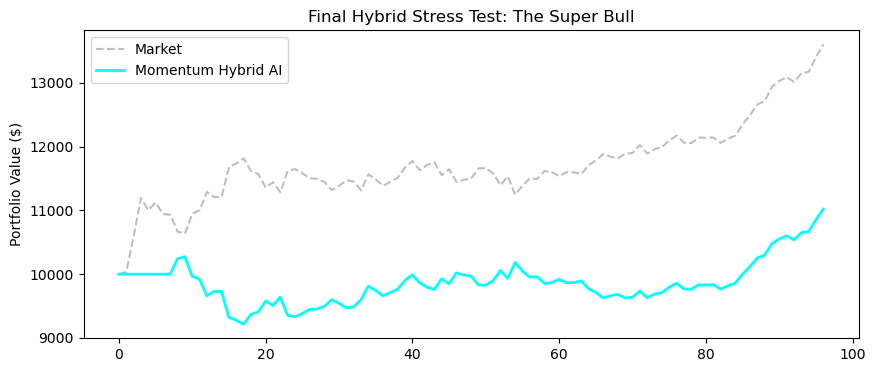

💰 AI Return:      10.19%
📉 Market Return:  36.06%
🔄 Trades Made:    4
🐢 VERDICT: AI Lost.

🧪 TESTING HYBRID SYSTEM: THE BEAR CRASH
📅 (2022-03-08 to 2022-11-01)


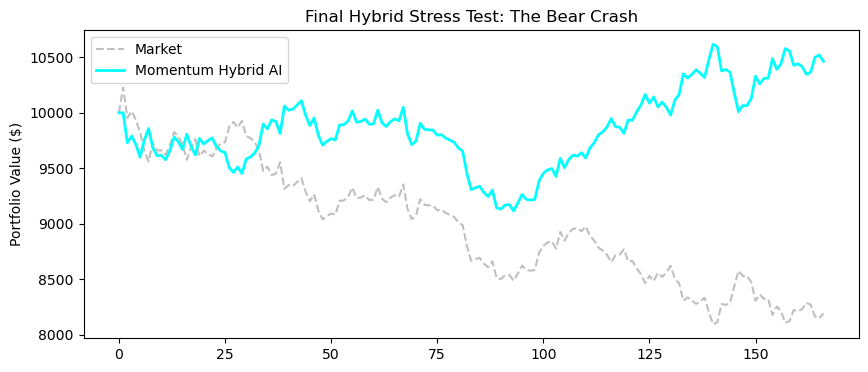

💰 AI Return:      4.65%
📉 Market Return:  -18.09%
🔄 Trades Made:    6
🏆 VERDICT: AI WON.

🧪 TESTING HYBRID SYSTEM: THE STABLE CHOP
📅 (2021-01-01 to 2021-12-31)


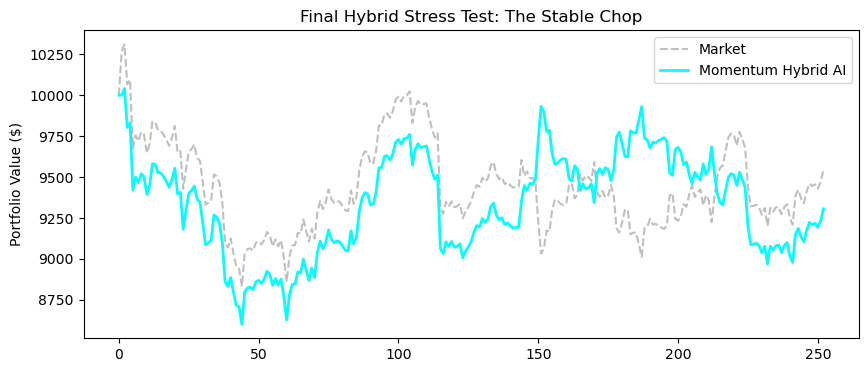

💰 AI Return:      -6.94%
📉 Market Return:  -4.54%
🔄 Trades Made:    3
🐢 VERDICT: AI Lost.


In [ ]:
# --- PHASE Z: THE HYBRID STRESS TEST (MOMENTUM OVERRIDE VERSION) ---
import tensorflow as tf
import matplotlib.pyplot as plt

def run_hybrid_stress_test(regime_name, start_date, end_date):
    print(f"\n==================================================")
    print(f"🧪 TESTING HYBRID SYSTEM: {regime_name.upper()}")
    print(f"📅 ({start_date} to {end_date})")
    print(f"==================================================")

    # 1. Load Specialists
    try:
        bull_model = tf.keras.models.load_model("Gold_BULL_Specialist.keras")
        bear_model = tf.keras.models.load_model("Gold_BEAR_Specialist.keras")
    except Exception as e:
        print(f"⚠️ Error loading models: {e}")
        return

    # 2. Slice Data
    try:
        subset = data.loc[start_date:end_date].copy()
    except KeyError:
        print("⚠️ Error: Date range not found.")
        return

    # 3. Prepare Data
    start_idx = data.index.get_loc(subset.index[0])
    end_idx = data.index.get_loc(subset.index[-1])
    
    X_regime = []
    
    # RAW DATA FOR MANAGER DECISIONS
    # We grab ALL indicators needed for the decision
    sma_200_vals = data['SMA_200'].values
    sma_20_vals = data['SMA_20'].values
    close_vals = data['Close'].values
    rsi_vals = data['RSI'].values  # <--- NEW: Need RSI for the test
    real_returns = data['Log_Ret'].values
    
    regime_decisions = [] 
    
    for i in range(start_idx, end_idx + 1):
        window = scaled_features[i-time_steps:i, :]
        if len(window) == time_steps:
            X_regime.append(window)
            
            # --- MANAGER LOGIC (Exact Match to Part 8) ---
            price_now = close_vals[i]
            s200 = sma_200_vals[i]
            s20 = sma_20_vals[i]
            rsi_now = rsi_vals[i]
            
            # 1. The Safe Rule (Golden Cross)
            golden_cross = (s20 > s200)
            
            # 2. The Speed Rule (Momentum Override)
            momentum_push = (rsi_now > 69)
            
            # COMBINED DECISION:
            is_bull_regime = (price_now > s200) and (golden_cross or momentum_push)
            
            regime_decisions.append(1 if is_bull_regime else 0)
            
    X_regime = np.array(X_regime)
    
    # 4. Get Expert Opinions
    bull_probs = bull_model.predict(X_regime, verbose=0)
    bear_probs = bear_model.predict(X_regime, verbose=0)
    
    # 5. Make Final Decisions
    final_preds = []
    for i in range(len(regime_decisions)):
        if regime_decisions[i] == 1:
            final_preds.append(np.argmax(bull_probs[i])) # Bull Specialist
        else:
            final_preds.append(np.argmax(bear_probs[i])) # Bear Specialist

    # 6. PnL Simulation (With Sticky Hold)
    initial_cash = 500
    ai_cash = initial_cash
    bench_cash = initial_cash
    ai_curve = [initial_cash]
    bench_curve = [initial_cash]
    
    position = 0 
    trade_count = 0
    
    subset_returns = real_returns[start_idx : start_idx + len(final_preds)]
    
    for i in range(len(final_preds)):
        ret = subset_returns[i]
        
        # Apply PnL
        if position == 1: ai_cash *= (1 + ret)
        elif position == -1: ai_cash *= (1 - ret)
        bench_cash *= (1 + ret)
        
        # Trade Logic
        signal = final_preds[i]
        new_position = position
        
        if signal == 1: new_position = 1    # Buy
        elif signal == 2: new_position = -1 # Sell
        # If signal is 0 (HOLD), keep 'new_position' same as 'position'
        
        if new_position != position:
            trade_count += 1
            position = new_position
        
        ai_curve.append(ai_cash)
        bench_curve.append(bench_cash)

    # 7. Visualize
    plt.figure(figsize=(10, 4))
    plt.plot(bench_curve, label='Market', color='gray', linestyle='--', alpha=0.5)
    plt.plot(ai_curve, label='Momentum Hybrid AI', color='cyan', linewidth=2)
    plt.title(f'Final Hybrid Stress Test: {regime_name}')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.show()

    # 8. Report
    ai_ret = ((ai_cash - initial_cash) / initial_cash) * 100
    bench_ret = ((bench_cash - initial_cash) / initial_cash) * 100
    print(f"💰 AI Return:      {ai_ret:.2f}%")
    print(f"📉 Market Return:  {bench_ret:.2f}%")
    print(f"🔄 Trades Made:    {trade_count}")
    
    if ai_ret > bench_ret: print("🏆 VERDICT: AI WON.")
    else: print("🐢 VERDICT: AI Lost.")

# --- EXECUTE ---
run_hybrid_stress_test("The Super Bull", "2020-03-20", "2020-08-05")
run_hybrid_stress_test("The Bear Crash", "2022-03-08", "2022-11-01")
run_hybrid_stress_test("The Stable Chop", "2021-01-01", "2021-12-31")


👻 STARTING HALLUCINATION CHECK (NOISE TEST)
🧠 Feeding 920 days of PURE NOISE to the models...

--- DIAGNOSTIC REPORT ---

🐂 BULL Behavior on Noise:
  - HOLD %: 100.0%
  - BUY %:  0.0% (Hallucinations)

🐻 BEAR Behavior on Noise:
  - HOLD %: 81.5%
  - SELL %: 18.5% (Paranoia)


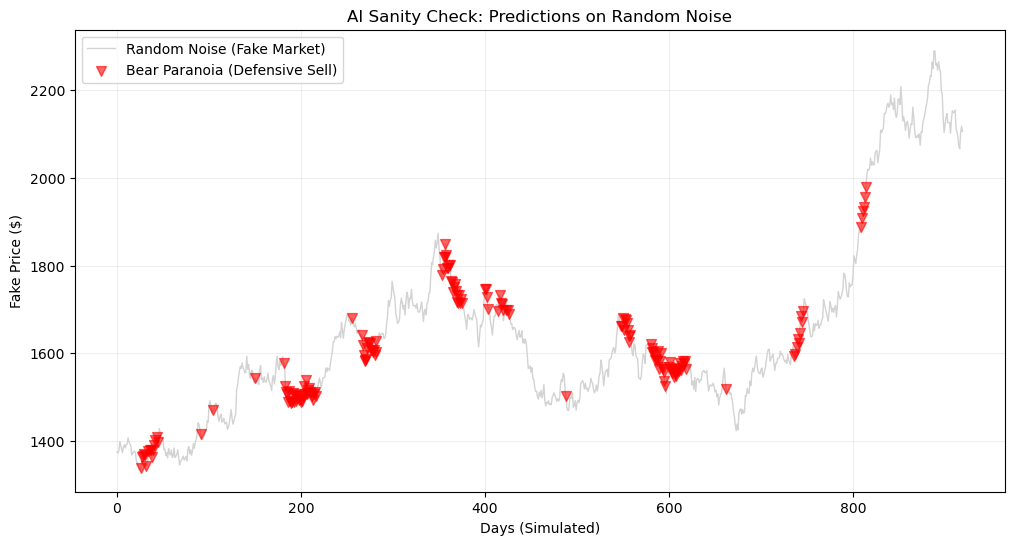

In [98]:
# --- PHASE X: THE HALLUCINATION TEST (SANITY CHECK) ---
# --- PHASE X: THE HALLUCINATION TEST (VISUALIZATION UPDATE) ---
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

def run_hallucination_test():
    print("\n==================================================")
    print("👻 STARTING HALLUCINATION CHECK (NOISE TEST)")
    print("==================================================")
    
    # 1. Generate Random Walk Data (Fake Stock)
    np.random.seed(42) # Fixed seed so we get the same 'random' noise every time
    days = 1000
    
    # Generate random daily returns (mean=0, std=1%)
    random_returns = np.random.normal(loc=0.0002, scale=0.01, size=days)
    price_path = [1500] # Start at $1500 Gold Price
    
    for r in random_returns:
        price_path.append(price_path[-1] * (1 + r))
        
    fake_data = pd.DataFrame({'Close': price_path[:-1], 'High': price_path[:-1], 'Low': price_path[:-1]})
    
    # 2. Recreate Indicators on Fake Data
    # We must match EXACTLY what the model expects
    fake_data['Log_Ret'] = np.log(fake_data['Close'] / fake_data['Close'].shift(1))
    
    # Fake Volatility (Since High=Low=Close in our simple walk, we add noise)
    fake_data['Parkinson_Vol'] = fake_data['Log_Ret'].rolling(20).std()
    
    # Fake Close Loc (Random)
    fake_data['Close_Loc'] = np.random.uniform(0, 1, size=len(fake_data))
    
    # Fake SMA Distance
    fake_data['SMA_20'] = fake_data['Close'].rolling(20).mean()
    fake_data['Dist_SMA_20'] = (fake_data['Close'] - fake_data['SMA_20']) / fake_data['SMA_20']
    
    # Fake RSI
    delta = fake_data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss.replace(0, 1e-9)
    fake_data['RSI'] = 100 - (100 / (1 + rs))
    
    # Cleanup
    fake_data.dropna(inplace=True)
    
    # 3. Scale and Shape (Must match training scaler)
    # Note: In a strict test, we'd refit scaler, but using the trained one 
    # checks if the model recognizes this data as 'alien' or 'normal'.
    features = ['Log_Ret', 'Dist_SMA_20', 'RSI', 'Parkinson_Vol', 'Close_Loc']
    fake_scaled = scaler.transform(fake_data[features])
    
    X_fake = []
    for i in range(60, len(fake_scaled)):
        X_fake.append(fake_scaled[i-60:i, :])
    X_fake = np.array(X_fake)
    
    # 4. Load Models
    try:
        bull_model = tf.keras.models.load_model("Gold_BULL_Specialist.keras")
        bear_model = tf.keras.models.load_model("Gold_BEAR_Specialist.keras")
    except:
        print("Models not found.")
        return

# 5. Predict on Garbage
    print(f"🧠 Feeding {len(X_fake)} days of PURE NOISE to the models...")
    bull_probs = bull_model.predict(X_fake, verbose=0)
    bear_probs = bear_model.predict(X_fake, verbose=0)
    
    # 6. Analyze Confidence & Signals
    bull_signals = np.argmax(bull_probs, axis=1) # 0=Hold, 1=Buy, 2=Sell
    bear_signals = np.argmax(bear_probs, axis=1) # 0=Hold, 1=Buy, 2=Sell
    
    print("\n--- DIAGNOSTIC REPORT ---")
    print("\n🐂 BULL Behavior on Noise:")
    print(f"  - HOLD %: {np.mean(bull_signals==0)*100:.1f}%")
    print(f"  - BUY %:  {np.mean(bull_signals==1)*100:.1f}% (Hallucinations)")
    
    print("\n🐻 BEAR Behavior on Noise:")
    print(f"  - HOLD %: {np.mean(bear_signals==0)*100:.1f}%")
    print(f"  - SELL %: {np.mean(bear_signals==2)*100:.1f}% (Paranoia)")

    # 7. Visualization (The New Part)
    plt.figure(figsize=(12, 6))
    
    # A. Plot the Fake Price
    # We need to align the price with the predictions (skip first 60 days)
    # The 'indices' for predictions start at 0, which corresponds to day 60 in data
    plot_prices = fake_data['Close'].iloc[60:].values
    plt.plot(plot_prices, label='Random Noise (Fake Market)', color='lightgray', linewidth=1)
    
    # B. Plot BULL "Fake Buys" (Green Up Triangles)
    bull_buy_idx = np.where(bull_signals == 1)[0]
    if len(bull_buy_idx) > 0:
        plt.scatter(bull_buy_idx, plot_prices[bull_buy_idx], 
                   color='#00ff00', marker='^', s=50, edgecolors='black', 
                   label='Bull Hallucination (False Buy)', zorder=3)
    
    # C. Plot BEAR "Paranoid Sells" (Red Down Triangles)
    bear_sell_idx = np.where(bear_signals == 2)[0]
    if len(bear_sell_idx) > 0:
        plt.scatter(bear_sell_idx, plot_prices[bear_sell_idx], 
                   color='red', marker='v', s=50, alpha=0.6, 
                   label='Bear Paranoia (Defensive Sell)', zorder=2)

    plt.title("AI Sanity Check: Predictions on Random Noise")
    plt.xlabel("Days (Simulated)")
    plt.ylabel("Fake Price ($)")
    plt.legend(loc='best')
    plt.grid(True, alpha=0.2)
    plt.show()

# Run it
run_hallucination_test()


🧪 TESTING HYBRID SYSTEM: RECENT MARKET (LATE 2025)
📅 (2025-07-01 to 2025-12-31)


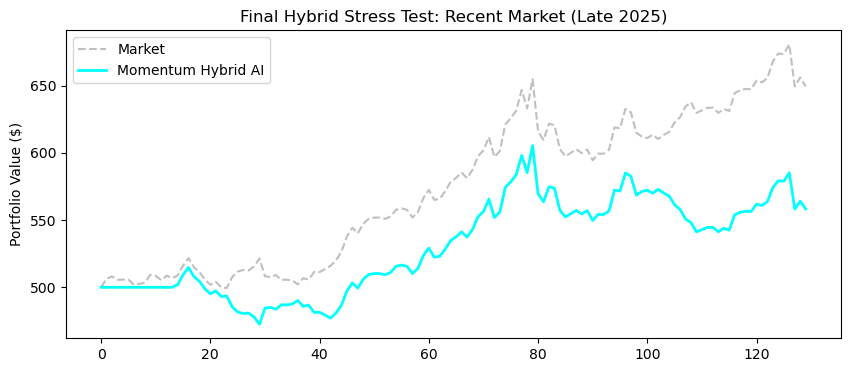

💰 AI Return:      11.65%
📉 Market Return:  29.90%
🔄 Trades Made:    5
🐢 VERDICT: AI Lost.


In [99]:
# Test period: July 1st, 2025 to Dec 31st, 2025
run_hybrid_stress_test("Recent Market (Late 2025)", "2025-07-01", "2025-12-31")

In [102]:
# --- PHASE Z: THE $10 MICRO TEST ---
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def run_micro_account_test(start_cash):
    print(f"\n==================================================")
    print(f"💰 TESTING MICRO-ACCOUNT: Starting with ${start_cash}")
    print(f"📅 Period: Late 2025 (2025-07-01 to 202-2-6)")
    print(f"==================================================")

    # 1. Setup
    start_date = "2025-07-01"
    end_date = "2025-12-31"
    
    # Load Models
    try:
        bull_model = tf.keras.models.load_model("Gold_BULL_Specialist.keras")
        bear_model = tf.keras.models.load_model("Gold_BEAR_Specialist.keras")
    except:
        print("⚠️ Models not found.")
        return

    # 2. Get Data
    subset = data.loc[start_date:end_date].copy()
    start_idx = data.index.get_loc(subset.index[0])
    end_idx = data.index.get_loc(subset.index[-1])
    
    # 3. Simulation Loop
    X_regime = []
    regime_decisions = []
    
    # Raw Data for Logic
    sma_200_vals = data['SMA_200'].values
    sma_20_vals = data['SMA_20'].values
    close_vals = data['Close'].values
    rsi_vals = data['RSI'].values
    real_returns = data['Log_Ret'].values
    
    for i in range(start_idx, end_idx + 1):
        window = scaled_features[i-time_steps:i, :]
        if len(window) == time_steps:
            X_regime.append(window)
            
            # --- STRICT MANAGER LOGIC (RSI > 69) ---
            price_now = close_vals[i]
            s200 = sma_200_vals[i]
            s20 = sma_20_vals[i]
            rsi_now = rsi_vals[i]
            
            golden_cross = (s20 > s200)
            momentum_push = (rsi_now > 69) # <--- STRICT RULE
            
            is_bull_regime = (price_now > s200) and (golden_cross or momentum_push)
            regime_decisions.append(1 if is_bull_regime else 0)
            
    X_regime = np.array(X_regime)
    
    # 4. Predictions
    bull_probs = bull_model.predict(X_regime, verbose=0)
    bear_probs = bear_model.predict(X_regime, verbose=0)
    
    final_preds = []
    for i in range(len(regime_decisions)):
        if regime_decisions[i] == 1:
            final_preds.append(np.argmax(bull_probs[i]))
        else:
            final_preds.append(np.argmax(bear_probs[i]))

    # 5. PnL with $10
    ai_cash = start_cash
    bench_cash = start_cash
    position = 0
    
    subset_returns = real_returns[start_idx : start_idx + len(final_preds)]
    
    for i in range(len(final_preds)):
        ret = subset_returns[i]
        
        if position == 1: ai_cash *= (1 + ret)
        elif position == -1: ai_cash *= (1 - ret)
        bench_cash *= (1 + ret)
        
        signal = final_preds[i]
        new_position = position
        if signal == 1: new_position = 1
        elif signal == 2: new_position = -1
        
        if new_position != position:
            position = new_position

    # 6. Results
    profit = ai_cash - start_cash
    print(f"💵 Starting Balance: ${start_cash:.2f}")
    print(f"💰 Final Balance:    ${ai_cash:.2f}")
    print(f"📈 Total Profit:     ${profit:.2f} (+{((ai_cash-start_cash)/start_cash)*100:.2f}%)")

# Run it
run_micro_account_test(500)


💰 TESTING MICRO-ACCOUNT: Starting with $500
📅 Period: Late 2025 (2025-07-01 to 202-2-6)
💵 Starting Balance: $500.00
💰 Final Balance:    $558.26
📈 Total Profit:     $58.26 (+11.65%)


In [104]:
# --- DIAGNOSTIC: WHY ISN'T IT SELLING? ---
print("\n--- 🛠️ DIAGNOSTIC REPORT ---")

# 1. Check the raw counts of predictions
unique, counts = np.unique(preds, return_counts=True)
pred_counts = dict(zip(unique, counts))

print("Prediction Counts in Test Set:")
print(f" - [0] HOLD: {pred_counts.get(0, 0)}")
print(f" - [1] BUY:  {pred_counts.get(1, 0)}")
print(f" - [2] SELL: {pred_counts.get(2, 0)}")

# 2. Check the average confidence for each class
mean_probs = probs.mean(axis=0)
print(f"\nAverage Probabilities Across Test Set:")
print(f" - Mean HOLD Prob: {mean_probs[0]:.4f}")
print(f" - Mean BUY Prob:  {mean_probs[1]:.4f}")
print(f" - Mean SELL Prob: {mean_probs[2]:.4f}")

# 3. Check if 'Sell' ever had the highest probability
if pred_counts.get(2, 0) == 0:
    max_sell_prob = probs[:, 2].max()
    print(f"\n❌ ALERT: The model NEVER predicted SELL.")
    print(f"Highest confidence it ever had for SELL was: {max_sell_prob:.4f}")
    print("Suggestion: Increase Class Weights for SELL or check if data is skewed.")
else:
    print(f"\n✅ The model DID predict SELL {pred_counts[2]} times.")


--- 🛠️ DIAGNOSTIC REPORT ---
Prediction Counts in Test Set:
 - [0] HOLD: 796
 - [1] BUY:  170
 - [2] SELL: 92

Average Probabilities Across Test Set:
 - Mean HOLD Prob: 0.4031
 - Mean BUY Prob:  0.3112
 - Mean SELL Prob: 0.2856

✅ The model DID predict SELL 92 times.


In [ ]:
import os

notebook_path = "your_notebook.ipynb"

# Fast conversion
os.system(f"jupyter nbconvert --to pdf {notebook_path}")

